In [87]:
using DifferentialEquations
using Plots

In [88]:
function DDOL_2modules(du,u,p,t)

    v00,v10,v01,v11 = u
    bA,bB,n,umax,G,r,D,cA,cB,dA,dB = p
    v_populations = [ v00 , v10 , v01 , v11 ]
    total_pop = sum( v_populations )
    
    u_00 = ( umax * G ) / ( 1.0 + ( 0 * bA + 0 * bB ) ^ n )
    u_10 = ( umax * G ) / ( 1.0 + ( 1 * bA + 0 * bB ) ^ n )
    u_01 = ( umax * G ) / ( 1.0 + ( 0 * bA + 1 * bB ) ^ n )
    u_11 = ( umax * G ) / ( 1.0 + ( 1 * bA + 1 * bB ) ^ n )
    
    v00_growth = u_00 * v00 * ( 1.0 - ( total_pop / r ) ) - D * v00
    v10_growth = u_10 * v10 * ( 1.0 - ( total_pop / r ) ) - D * v10
    v01_growth = u_01 * v01 * ( 1.0 - ( total_pop / r ) ) - D * v01
    v11_growth = u_11 * v11 * ( 1.0 - ( total_pop / r ) ) - D * v11
    
    modA = cA * ( v10 + v11 )
    modB = cB * ( v01 + v11 )
    
    v00_conjugation = ( - ( modA * v00 ) + ( dA * v10 ) 
                        - ( modB * v00 ) + ( dB * v01 ) )
    v10_conjugation = ( + ( modA * v00 ) - ( dA * v10 )
                        - ( modB * v10 ) + ( dB * v11 ) )
    v01_conjugation = ( - ( modA * v01 ) + ( dA * v11 ) 
                        + ( modB * v00 ) - ( dB * v01 ) )  
    v11_conjugation = ( + ( modA * v01 ) - ( dA * v11 ) 
                        + ( modB * v10 ) - ( dB * v11 ) )

    du[1] = dv00 = v00_conjugation + v00_growth
    du[2] = dv10 = v10_conjugation + v10_growth
    du[3] = dv01 = v01_conjugation + v01_growth
    du[4] = dv11 = v11_conjugation + v11_growth
    
end

function monoculture_with_dual_selection(du,u,p,t)
    vM = u[1]
    burden,n,umax,G,r,D = p
    
    u_M = ( umax * G ) / ( 1.0 + ( burden ) ^ n )
    
    vM_growth = u_M * vM * ( 1.0 - ( vM / r ) ) - D * vM

    du[1] = dvM = vM_growth
end

function SDOL_2modules(du,u,p,t)
    vA,vB = u
    bA,bB,n,umax,G,r,D = p
    v_populations = [ vA , vB ]
    total_pop = sum( v_populations )
    
    u_A = ( umax * G ) / ( 1.0 + ( 1 * bA + 0 * bB ) ^ n )
    u_B = ( umax * G ) / ( 1.0 + ( 0 * bA + 1 * bB ) ^ n )
    
    vA_growth = u_A * vA * ( 1.0 - ( total_pop / r ) ) - D * vA
    vB_growth = u_B * vB * ( 1.0 - ( total_pop / r ) ) - D * vB
    
    
    du[1] = dv10 = vA_growth
    du[2] = dv01 = vB_growth
end

SDOL_2modules (generic function with 1 method)

In [129]:
c_range = 0:0.002:0.1
avg_c = 0.05

transfer_rates = [0,0.01,0.02,0.05,0.1]

avg_umax = 1

D_range = 0:0.001:0.1
avg_D = 0.03

dilution_rates = [0,0.001,0.005,0.01,0.05]

d_range = 0:0.001:1
avg_d = 1e-3

n_range = 1:0.01:10
avg_n = 3

G_range = 0:0.01:1
avg_G = 1

avg_r = 1

simulation_time = 1000

burden_range = 0:0.05:4

colors = cgrad(:YlGnBu)
colors2 = :Greens

:Greens

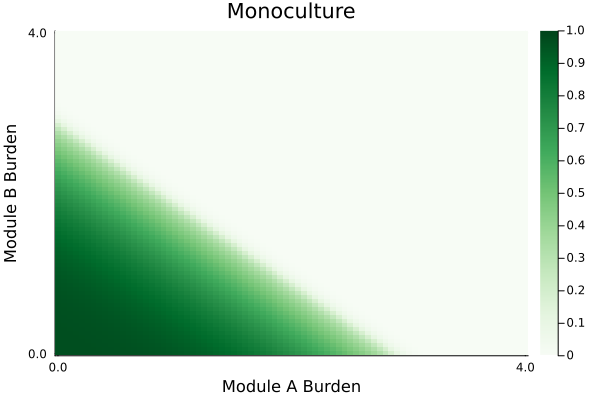

In [138]:
# p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
n = avg_n
umax = avg_umax
G = avg_G
r = avg_r
D = avg_D

time = simulation_time # simulated time IN HOURS
dP = 0.5 # Turnover rate of final product (non-dimensionalization term)
tspan_end = time * dP

steady_state_solutions = Array{Float64}(undef,length(burden_range),length(burden_range))


for burden_A_index in range(1,length(burden_range))
    
    module_A_burden = burden_range[burden_A_index]
    
    for burden_B_index in range(1,length(burden_range))
        
        module_B_burden = burden_range[burden_B_index]
        
        total_burden = module_A_burden + module_B_burden

        # Initial conditions and parameter values

        # u = [v11]
        u0 = [2e-3] # Initial values for S0, S1, S2, S3

        # p = (b, n,  umax,G,  r,    D )
        p = [  total_burden,n,umax,G,r,D] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB
    


        # Time span for integration
        tspan = (0.0, tspan_end)  # Start and end times for integration

        # Define the ODE problem
        prob = ODEProblem(monoculture_with_dual_selection, u0, tspan, p)

        # Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
        solver = Tsit5()

        # Solve the ODE problem
        sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

        module_A = sol[1, :]/r
        module_B = sol[1, :]/r

        module_A_SS = max(0,last(module_A))
        module_B_SS = max(0,last(module_B))
        geometric_average_SS = (module_A_SS * module_B_SS) ^ 0.5


        steady_state_solutions[burden_B_index,burden_A_index] = geometric_average_SS

    end
end

axismax = length(burden_range)
axismax_value = last(burden_range)

asymmetric_burden_heatmap = heatmap(steady_state_solutions, c=colors2, axis=false, colorbar=true, title="Monoculture")

heatmap!(axis=true,            # Show axis
clim=(0.0, 1.0),  # Set z-axis limits
xticks=([1,axismax],[0,axismax_value]), # Set tick positions for x-axis
yticks=([1,axismax],[0,axismax_value]), # Set tick positions for y-axis
xlabel="Module A Burden",
ylabel="Module B Burden"
)

savefig(asymmetric_burden_heatmap,"mono.svg")
display(asymmetric_burden_heatmap)


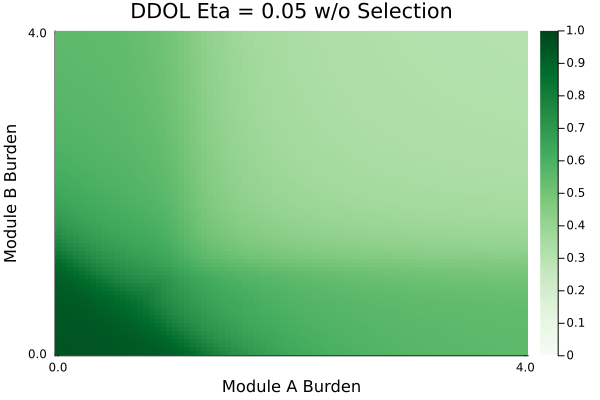

In [137]:
# p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
n = avg_n
umax = avg_umax
G = avg_G
r = avg_r
D = avg_D
dA = avg_d
dB = avg_d

transfer_rate = avg_c

time = simulation_time # simulated time IN HOURS
dP = 0.5 # Turnover rate of final product (non-dimensionalization term)
tspan_end = time * dP


steady_state_solutions = Array{Float64}(undef,length(burden_range),length(burden_range))


for burden_A_index in range(1,length(burden_range))
    
    module_A_burden = burden_range[burden_A_index]
    
    for burden_B_index in range(1,length(burden_range))
        
        module_B_burden = burden_range[burden_B_index]
        
        # Initial conditions and parameter values

        # u = [v00,v10, v01, v11]
        u0 = [0.0,1e-3,1e-3,0.0000] # Initial values for S0, S1, S2, S3

        # p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
        p = [  module_A_burden,module_B_burden,n,umax,G,r,D,transfer_rate,transfer_rate,dA,dB] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB

        # Time span for integration
        tspan = (0.0, tspan_end)  # Start and end times for integration

        # Define the ODE problem
        prob = ODEProblem(DDOL_2modules, u0, tspan, p)

        # Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
        solver = Tsit5()

        # Solve the ODE problem
        sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

        module_A = sol[2, :]/r + sol[4, :]/r
        module_B = sol[3, :]/r + sol[4, :]/r

        module_A_SS = max(0,last(module_A))
        module_B_SS = max(0,last(module_B))
        geometric_average_SS = (module_A_SS * module_B_SS) ^ 0.5


        steady_state_solutions[burden_B_index,burden_A_index] = geometric_average_SS

    end
end

axismax = length(burden_range)
axismax_value = last(burden_range)

asymmetric_burden_heatmap = heatmap(steady_state_solutions, c=colors2, axis=false, colorbar=true, title="DDOL Eta = $transfer_rate w/o Selection")

heatmap!(axis=true,            # Show axis
clim=(0.0, 1.0),  # Set z-axis limits
xticks=([1,axismax],[0,axismax_value]), # Set tick positions for x-axis
yticks=([1,axismax],[0,axismax_value]), # Set tick positions for y-axis
xlabel="Module A Burden",
ylabel="Module B Burden")

savefig(asymmetric_burden_heatmap,"DDOL.svg")
display(asymmetric_burden_heatmap)

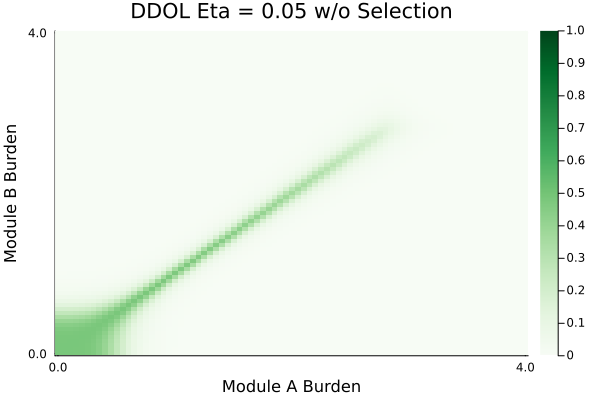

In [136]:
# p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
n = avg_n
umax = avg_umax
G = avg_G
r = avg_r
D = avg_D
dA = avg_d
dB = avg_d


time = simulation_time # simulated time IN HOURS
dP = 0.5 # Turnover rate of final product (non-dimensionalization term)
tspan_end = time * dP


steady_state_solutions = Array{Float64}(undef,length(burden_range),length(burden_range))


for burden_A_index in range(1,length(burden_range))
    
    module_A_burden = burden_range[burden_A_index]
    
    for burden_B_index in range(1,length(burden_range))
        
        module_B_burden = burden_range[burden_B_index]
        
        # Initial conditions and parameter values

        # u = [v10, v01]
        u0 = [1e-3,1e-3] # Initial values for S0, S1, S2, S3

        # p = (bA,bB,n,umax,G,r,D)
        p = [  module_A_burden,module_B_burden,n,umax,G,r,D] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB

        # Time span for integration
        tspan = (0.0, tspan_end)  # Start and end times for integration

        # Define the ODE problem
        prob = ODEProblem(SDOL_2modules, u0, tspan, p)

        # Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
        solver = Tsit5()

        # Solve the ODE problem
        sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

        module_A = sol[1, :]/r
        module_B = sol[2, :]/r

        module_A_SS = max(0,last(module_A))
        module_B_SS = max(0,last(module_B))
        geometric_average_SS = (module_A_SS * module_B_SS) ^ 0.5


        steady_state_solutions[burden_B_index,burden_A_index] = geometric_average_SS

    end
end

axismax = length(burden_range)
axismax_value = last(burden_range)



asymmetric_burden_heatmap = heatmap(steady_state_solutions, c=colors2, axis=false, colorbar=true, title="DDOL Eta = $transfer_rate w/o Selection")

heatmap!(axis=true,            # Show axis
clim=(0.0, 1.0),  # Set z-axis limits
xticks=([1,axismax],[0,axismax_value]), # Set tick positions for x-axis
yticks=([1,axismax],[0,axismax_value]), # Set tick positions for y-axis
xlabel="Module A Burden",
ylabel="Module B Burden")

savefig(asymmetric_burden_heatmap,"SDOL.svg")
display(asymmetric_burden_heatmap)

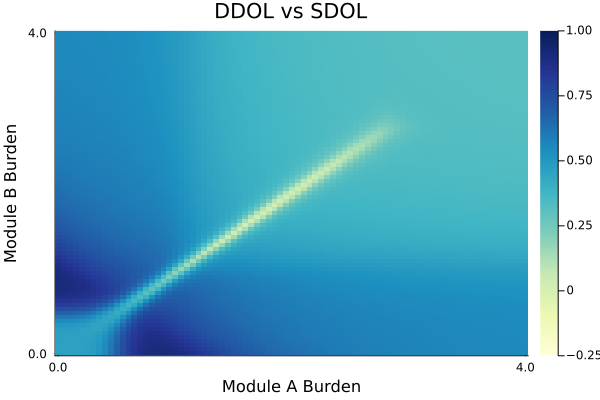

In [135]:
# p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
n = avg_n
umax = avg_umax
G = avg_G
r = avg_r
D = avg_D
dA = avg_d
dB = avg_d


time = simulation_time # simulated time IN HOURS
dP = 0.5 # Turnover rate of final product (non-dimensionalization term)
tspan_end = time * dP


SDOL_steady_state_solutions = Array{Float64}(undef,length(burden_range),length(burden_range))


for burden_A_index in range(1,length(burden_range))
    
    module_A_burden = burden_range[burden_A_index]
    
    for burden_B_index in range(1,length(burden_range))
        
        module_B_burden = burden_range[burden_B_index]
        
        # Initial conditions and parameter values

        # u = [v10, v01]
        u0 = [1e-3,1e-3] # Initial values for S0, S1, S2, S3

        # p = (bA,bB,n,umax,G,r,D)
        p = [  module_A_burden,module_B_burden,n,umax,G,r,D] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB

        # Time span for integration
        tspan = (0.0, tspan_end)  # Start and end times for integration

        # Define the ODE problem
        prob = ODEProblem(SDOL_2modules, u0, tspan, p)

        # Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
        solver = Tsit5()

        # Solve the ODE problem
        sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

        module_A = sol[1, :]/r
        module_B = sol[2, :]/r

        module_A_SS = max(0,last(module_A))
        module_B_SS = max(0,last(module_B))
        geometric_average_SS = (module_A_SS * module_B_SS) ^ 0.5


        SDOL_steady_state_solutions[burden_B_index,burden_A_index] = geometric_average_SS

    end
end


mono_steady_state_solutions = Array{Float64}(undef,length(burden_range),length(burden_range))


for burden_A_index in range(1,length(burden_range))
    
    module_A_burden = burden_range[burden_A_index]
    
    for burden_B_index in range(1,length(burden_range))
        
        module_B_burden = burden_range[burden_B_index]
        
        total_burden = module_A_burden + module_B_burden

        # Initial conditions and parameter values

        # u = [v11]
        u0 = [2e-3] # Initial values for S0, S1, S2, S3

        # p = (b, n,  umax,G,  r,    D )
        p = [  total_burden,n,umax,G,r,D] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB
    


        # Time span for integration
        tspan = (0.0, tspan_end)  # Start and end times for integration

        # Define the ODE problem
        prob = ODEProblem(monoculture_with_dual_selection, u0, tspan, p)

        # Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
        solver = Tsit5()

        # Solve the ODE problem
        sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

        module_A = sol[1, :]/r
        module_B = sol[1, :]/r

        module_A_SS = max(0,last(module_A))
        module_B_SS = max(0,last(module_B))
        geometric_average_SS = (module_A_SS * module_B_SS) ^ 0.5


        mono_steady_state_solutions[burden_B_index,burden_A_index] = geometric_average_SS

    end
end

mono_SDOL_steady_state_solutions = Array{Float64}(undef,length(burden_range),length(burden_range))


for burden_A_index in range(1,length(burden_range))    
    for burden_B_index in range(1,length(burden_range))
        mono = mono_steady_state_solutions[burden_B_index,burden_A_index]
        SDOL = SDOL_steady_state_solutions[burden_B_index,burden_A_index]
        winner = max(0,SDOL)
        mono_SDOL_steady_state_solutions[burden_B_index,burden_A_index] = winner
    end
end


DDOL_steady_state_solutions = Array{Float64}(undef,length(burden_range),length(burden_range))


for burden_A_index in range(1,length(burden_range))
    
    module_A_burden = burden_range[burden_A_index]
    
    for burden_B_index in range(1,length(burden_range))
        
        module_B_burden = burden_range[burden_B_index]
        
        # Initial conditions and parameter values

        # u = [v00,v10, v01, v11]
        u0 = [0.0,1e-3,1e-3,0.0000] # Initial values for S0, S1, S2, S3

        # p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
        p = [  module_A_burden,module_B_burden,n,umax,G,r,D,transfer_rate,transfer_rate,dA,dB] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB

        # Time span for integration
        tspan = (0.0, tspan_end)  # Start and end times for integration

        # Define the ODE problem
        prob = ODEProblem(DDOL_2modules, u0, tspan, p)

        # Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
        solver = Tsit5()

        # Solve the ODE problem
        sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

        module_A = sol[2, :]/r + sol[4, :]/r
        module_B = sol[3, :]/r + sol[4, :]/r

        module_A_SS = max(0,last(module_A))
        module_B_SS = max(0,last(module_B))
        geometric_average_SS = (module_A_SS * module_B_SS) ^ 0.5


        DDOL_steady_state_solutions[burden_B_index,burden_A_index] = geometric_average_SS

    end
end

DDOLvsTrad_steady_state_solutions = DDOL_steady_state_solutions .- mono_SDOL_steady_state_solutions

axismax = length(burden_range)
axismax_value = last(burden_range)

value_range = maximum(DDOLvsTrad_steady_state_solutions)-minimum(DDOLvsTrad_steady_state_solutions)
zero = abs(minimum(DDOLvsTrad_steady_state_solutions))


asymmetric_burden_heatmap = heatmap(DDOLvsTrad_steady_state_solutions, c=colors, axis=false, colorbar=true, title="DDOL vs SDOL")

heatmap!(axis=true,            # Show axis
clim=(-0.25, 1),  # Set z-axis limits
xticks=([1,axismax],[0,axismax_value]), # Set tick positions for x-axis
yticks=([1,axismax],[0,axismax_value]), # Set tick positions for y-axis
xlabel="Module A Burden",
ylabel="Module B Burden")

savefig(asymmetric_burden_heatmap,"DDOLvsSDOL.svg")
display(asymmetric_burden_heatmap)

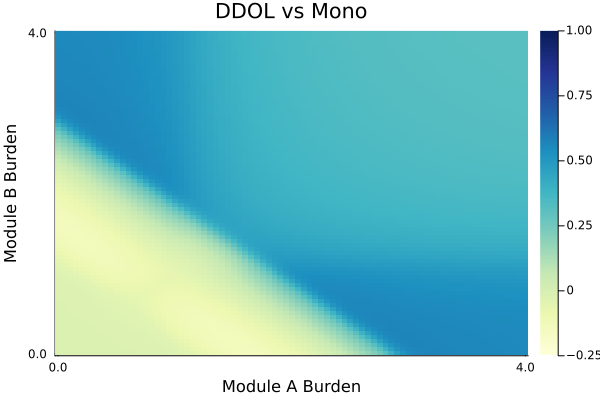

In [134]:
# p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
n = avg_n
umax = avg_umax
G = avg_G
r = avg_r
D = avg_D
dA = avg_d
dB = avg_d


time = simulation_time # simulated time IN HOURS
dP = 0.5 # Turnover rate of final product (non-dimensionalization term)
tspan_end = time * dP


SDOL_steady_state_solutions = Array{Float64}(undef,length(burden_range),length(burden_range))


for burden_A_index in range(1,length(burden_range))
    
    module_A_burden = burden_range[burden_A_index]
    
    for burden_B_index in range(1,length(burden_range))
        
        module_B_burden = burden_range[burden_B_index]
        
        # Initial conditions and parameter values

        # u = [v10, v01]
        u0 = [1e-3,1e-3] # Initial values for S0, S1, S2, S3

        # p = (bA,bB,n,umax,G,r,D)
        p = [  module_A_burden,module_B_burden,n,umax,G,r,D] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB

        # Time span for integration
        tspan = (0.0, tspan_end)  # Start and end times for integration

        # Define the ODE problem
        prob = ODEProblem(SDOL_2modules, u0, tspan, p)

        # Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
        solver = Tsit5()

        # Solve the ODE problem
        sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

        module_A = sol[1, :]/r
        module_B = sol[2, :]/r

        module_A_SS = max(0,last(module_A))
        module_B_SS = max(0,last(module_B))
        geometric_average_SS = (module_A_SS * module_B_SS) ^ 0.5


        SDOL_steady_state_solutions[burden_B_index,burden_A_index] = geometric_average_SS

    end
end


mono_steady_state_solutions = Array{Float64}(undef,length(burden_range),length(burden_range))


for burden_A_index in range(1,length(burden_range))
    
    module_A_burden = burden_range[burden_A_index]
    
    for burden_B_index in range(1,length(burden_range))
        
        module_B_burden = burden_range[burden_B_index]
        
        total_burden = module_A_burden + module_B_burden

        # Initial conditions and parameter values

        # u = [v11]
        u0 = [2e-3] # Initial values for S0, S1, S2, S3

        # p = (b, n,  umax,G,  r,    D )
        p = [  total_burden,n,umax,G,r,D] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB
    


        # Time span for integration
        tspan = (0.0, tspan_end)  # Start and end times for integration

        # Define the ODE problem
        prob = ODEProblem(monoculture_with_dual_selection, u0, tspan, p)

        # Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
        solver = Tsit5()

        # Solve the ODE problem
        sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

        module_A = sol[1, :]/r
        module_B = sol[1, :]/r

        module_A_SS = max(0,last(module_A))
        module_B_SS = max(0,last(module_B))
        geometric_average_SS = (module_A_SS * module_B_SS) ^ 0.5


        mono_steady_state_solutions[burden_B_index,burden_A_index] = geometric_average_SS

    end
end

mono_SDOL_steady_state_solutions = Array{Float64}(undef,length(burden_range),length(burden_range))


for burden_A_index in range(1,length(burden_range))    
    for burden_B_index in range(1,length(burden_range))
        mono = mono_steady_state_solutions[burden_B_index,burden_A_index]
        SDOL = SDOL_steady_state_solutions[burden_B_index,burden_A_index]
        winner = max(mono,0)
        mono_SDOL_steady_state_solutions[burden_B_index,burden_A_index] = winner
    end
end


DDOL_steady_state_solutions = Array{Float64}(undef,length(burden_range),length(burden_range))


for burden_A_index in range(1,length(burden_range))
    
    module_A_burden = burden_range[burden_A_index]
    
    for burden_B_index in range(1,length(burden_range))
        
        module_B_burden = burden_range[burden_B_index]
        
        # Initial conditions and parameter values

        # u = [v00,v10, v01, v11]
        u0 = [0.0,1e-3,1e-3,0.0000] # Initial values for S0, S1, S2, S3

        # p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
        p = [  module_A_burden,module_B_burden,n,umax,G,r,D,transfer_rate,transfer_rate,dA,dB] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB

        # Time span for integration
        tspan = (0.0, tspan_end)  # Start and end times for integration

        # Define the ODE problem
        prob = ODEProblem(DDOL_2modules, u0, tspan, p)

        # Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
        solver = Tsit5()

        # Solve the ODE problem
        sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

        module_A = sol[2, :]/r + sol[4, :]/r
        module_B = sol[3, :]/r + sol[4, :]/r

        module_A_SS = max(0,last(module_A))
        module_B_SS = max(0,last(module_B))
        geometric_average_SS = (module_A_SS * module_B_SS) ^ 0.5


        DDOL_steady_state_solutions[burden_B_index,burden_A_index] = geometric_average_SS

    end
end

DDOLvsTrad_steady_state_solutions = DDOL_steady_state_solutions .- mono_SDOL_steady_state_solutions

axismax = length(burden_range)
axismax_value = last(burden_range)

value_range = maximum(DDOLvsTrad_steady_state_solutions)-minimum(DDOLvsTrad_steady_state_solutions)
zero = abs(minimum(DDOLvsTrad_steady_state_solutions))


asymmetric_burden_heatmap = heatmap(DDOLvsTrad_steady_state_solutions, c=colors, axis=false, colorbar=true, title="DDOL vs Mono")

heatmap!(axis=true,            # Show axis
clim=(-0.25, 1),  # Set z-axis limits
xticks=([1,axismax],[0,axismax_value]), # Set tick positions for x-axis
yticks=([1,axismax],[0,axismax_value]), # Set tick positions for y-axis
xlabel="Module A Burden",
ylabel="Module B Burden")

savefig(asymmetric_burden_heatmap,"DDOLvsmono.svg")
display(asymmetric_burden_heatmap)

In [120]:
minimum(DDOLvsTrad_steady_state_solutions)

-0.13993251974760756